## Part 1: 
Load data, clean, and save aggregate data

In [1]:

import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import nfl_data_py as nfl
from data_cleaning import label_run_or_pass, reverse_deg, normalize_tracking, pivot_data, label_run_or_pass, change_columns_types
from data_loading import aggregate_data

#immport necessary libraries and filter warnings
from IPython.display import Image
import warnings


from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, f1_score, precision_score, recall_score, accuracy_score, cohen_kappa_score, roc_auc_score, confusion_matrix, log_loss, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize
from IPython.display import clear_output
from sklearn.decomposition import PCA
from colorama import Fore, Style
from tqdm import tqdm
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import optuna
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import Callback
import nfl_data_py as nfl
from sklearn.impute import SimpleImputer
warnings.filterwarnings("ignore")
root_dir = os.getcwd()

load_saved_data = True        # if you change this to true you can load presaved data

if not load_saved_data: 
    games_fname= os.path.join(root_dir, "data/games.csv")
    plays_fname = os.path.join(root_dir,  "data/plays.csv")
    players_fname = os.path.join(root_dir,  "data/players.csv")
    player_plays_fname = os.path.join(root_dir,  "data/player_play.csv")
    xp_fname = os.path.join(root_dir, "data/team_xpass_ratios.csv")
    pr_fname = os.path.join(root_dir, "data/team_pass_rates.csv")
    cf_fname = os.path.join(root_dir, "data/coverages_faced.csv")
    cu_fname = os.path.join(root_dir, 'data/coverages_used.csv')
    tracking_fname_list_train = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,9)] #weeks 1-8 are training data
    tracking_fname_list_test = [os.path.join(root_dir,  "data/tracking_week_9.csv")] #week 9 is test data
    train_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_train, games_fname, xp_fname, pr_fname, cf_fname, cu_fname)
    train_data.to_csv(os.path.join(root_dir, "data/train_data.csv"), index=False)
    test_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_test, games_fname, xp_fname, pr_fname, cf_fname, cu_fname)
    test_data.to_csv(os.path.join(root_dir, "data/test_data.csv"), index=False)
else:
    train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
    test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))
print('train colums: ', len(train_data.columns))
print('test colums: ', len(test_data.columns))

train colums:  438
test colums:  368


In [2]:
include_columns=test_data.columns
train_data=train_data[include_columns]
train_data.columns

Index(['gameId', 'playId', 'quarter', 'down', 'yardsToGo',
       'score_differential', 'time_remaining', 'playNullifiedByPenalty',
       'preSnapHomeTeamWinProbability', 'pass_rush_ratio',
       ...
       'Zone_off', 'cover_3_def', 'cover_6_def', 'cover_1_def', 'Quarters_def',
       'Cover-2_def', 'Cover-0_def', 'Man_def', 'Other_def', 'Zone_def'],
      dtype='object', length=368)

## Goal: 
To predict pass attempts for each play with greater accuracy and precision than the baseline dummy classifier. The base rate is about 60%. We will look at the offensive players' tracking data, along with characteristics of the play including the offensive formation and receiver alignment.

## General Strategy:
1. Read all data
2. Merge data
3. Filter data for offensive players, plays not nullified by a penalty, and data before the snap
4. Create a target variable 'pass' to indicate if a pass was attempted
5. Feature engineering and feature selection
6. Test baseline models
7. Tune models

In [3]:

for col in train_data.columns: 
    if round((train_data[col].isna().sum() /len(train_data)*100), 2)>75:
        train_data.drop(columns=col, inplace=True)
    elif round((train_data[col].isna().sum() /len(train_data)*100), 2)>0:
        print(col,round((train_data[col].isna().sum() /len(train_data)*100), 2), '% missing')
    else: 
        print(col)

gameId
playId
quarter
down
yardsToGo
score_differential
time_remaining 0.81 % missing
playNullifiedByPenalty
preSnapHomeTeamWinProbability
pass_rush_ratio 2.84 % missing
Rain
temp 9.67 % missing
humidity 5.64 % missing
wind 8.97 % missing
preSnapVisitorTeamWinProbability
absoluteYardlineNumber
pass
s|max|C_1
s|max|C_2
s|max|FB_1
s|max|G_1
s|max|G_2
s|max|G_3
s|max|ILB_1
s|max|QB_1
s|max|QB_2
s|max|RB_1
s|max|RB_2
s|max|TE_1
s|max|TE_2
s|max|TE_3
s|max|T_1
s|max|T_2
s|max|T_3
s|max|T_4
s|max|WR_1
s|max|WR_2
s|max|WR_3
s|max|WR_4
s|max|WR_5
a|max|C_1
a|max|C_2
a|max|FB_1
a|max|G_1
a|max|G_2
a|max|G_3
a|max|ILB_1
a|max|QB_1
a|max|QB_2
a|max|RB_1
a|max|RB_2
a|max|TE_1
a|max|TE_2
a|max|TE_3
a|max|T_1
a|max|T_2
a|max|T_3
a|max|T_4
a|max|WR_1
a|max|WR_2
a|max|WR_3
a|max|WR_4
a|max|WR_5
o_standard|mean|C_1
o_standard|mean|C_2
o_standard|mean|FB_1
o_standard|mean|G_1
o_standard|mean|G_2
o_standard|mean|G_3
o_standard|mean|ILB_1
o_standard|mean|QB_1
o_standard|mean|QB_2
o_standard|mean|RB_1
o_st

In [4]:
train_data.columns

Index(['gameId', 'playId', 'quarter', 'down', 'yardsToGo',
       'score_differential', 'time_remaining', 'playNullifiedByPenalty',
       'preSnapHomeTeamWinProbability', 'pass_rush_ratio',
       ...
       'Zone_off', 'cover_3_def', 'cover_6_def', 'cover_1_def', 'Quarters_def',
       'Cover-2_def', 'Cover-0_def', 'Man_def', 'Other_def', 'Zone_def'],
      dtype='object', length=368)

In [5]:
len(train_data.columns)

368

In [6]:
train_data=change_columns_types(train_data)
test_data=change_columns_types(test_data)

In [7]:
drop_columns=['playNullifiedByPenalty', 'gameId', 'playId']
features=[]
for col in train_data.columns:
    if 'Id' not in col and 'playNullifiedByPenalty' not in col:
        features.append(col)

In [8]:
#select final features based on correlation with target variable
correlations=train_data[features].corr()[['pass']]
final_features=list(correlations[((correlations['pass']>.03) | (correlations['pass']<-.03))].T.columns.values)

In [9]:
final_features = [x for x in final_features if 'std' not in x]

In [10]:
train_data[final_features].sum().astype(int).sort_values().head(20)

shiftSinceLineset|T_1        12
receiverAlignment_2x0        42
shiftSinceLineset|TE_3       64
offenseFormation_WILDCAT     79
receiverAlignment_4x1       109
offenseFormation_JUMBO      116
receiverAlignment_1x1       143
shiftSinceLineset|FB_1      149
a|max|WR_4                  183
s|max|QB_2                  199
s|max|WR_4                  250
shiftSinceLineset|WR_3      318
motionSinceLineset|TE_2     354
shiftSinceLineset|TE_2      366
shiftSinceLineset|WR_1      423
shiftSinceLineset|WR_2      428
shiftSinceLineset|RB_1      461
offenseFormation_PISTOL     553
dis|sum|QB_2                615
motionSinceLineset|WR_3     679
dtype: int32

In [11]:
#remove redundant features
threshold = .5
correlation_matrix = train_data[final_features].drop(columns='pass').corr()
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

In [12]:
final_features=list(set(final_features)-highly_correlated_features)

In [13]:
len(final_features)

62

In [14]:
numeric_columns=[]
for i in final_features:
    if train_data[i].dtype!='O' and i!='pass' and 'shiftSinceLineset' not in i and 'motionSinceLineset' not in i and  'offenseFormation' not in i and'receiverAlignment'not in i and 'Cover'not in i and 'roof' not in i and 'surface' not in i and 'is_no_huddle' not in i and 'is_no_motion' not in i:
        numeric_columns.append(i)

In [15]:
cat_columns=[]
for i in final_features:
    if i not in numeric_columns and i!='pass':
        cat_columns.append(i)

<Axes: title={'center': 'Correlation Heatmap of Features'}>

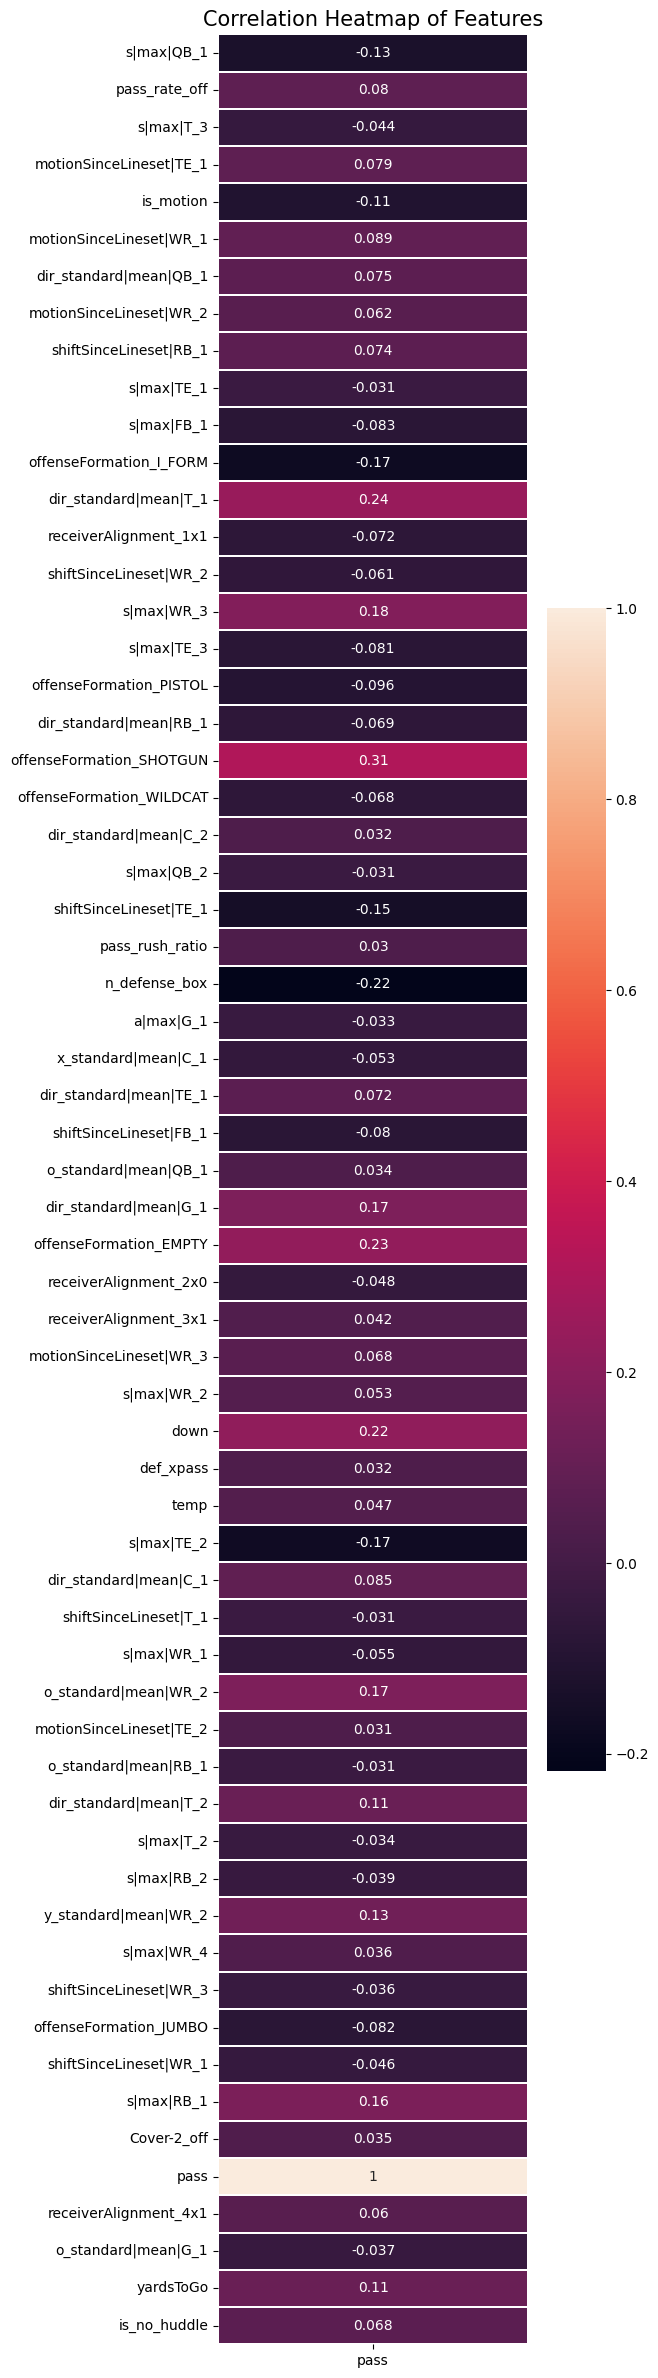

In [16]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,30))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(train_data[final_features].corr()[['pass']],linewidths=0.1,vmax=1.0,  linecolor='white', annot=True)

In [17]:
# Create an imputer object with mean strategy
#imputer = SimpleImputer(strategy='mean')
from sklearn.compose import ColumnTransformer

# Fit and transform the data
#merged_pivot[numeric_columns] = imputer.fit_transform(merged_pivot[numeric_columns])
imputer = SimpleImputer(missing_values = np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, numeric_columns),('scaler', MinMaxScaler(), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [18]:
#create a function to train ML models and return ROC_AUC and accuracy scores
SEED=42
n_splits=5
#X=merged_pivot[selected_features]
X=train_data[final_features].drop(columns='pass')

y=train_data['pass']


def TrainML(model_class, X, y):


    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    train_A = []
    test_A = []

    oof_non_rounded = np.zeros(len(y), dtype=float) 


    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        oof_non_rounded[test_idx] = y_val_pred
       
     

        train_auc = roc_auc_score(y_train, y_train_pred.round(0).astype(int))
        val_auc = roc_auc_score(y_val, y_val_pred.round(0))

        train_S.append(train_auc)
        test_S.append(val_auc)

        train_accuracy = accuracy_score(y_train, y_train_pred.round(0).astype(int))
        val_accuracy = accuracy_score(y_val, y_val_pred.round(0))

        train_A.append(train_accuracy)
        test_A.append(val_accuracy)
       
        
        print(f"Fold {fold+1} - Train AUC: {train_auc:.4f}, Validation AUC: {val_auc:.4f}")
        clear_output(wait=True)

    print(f"Mean Train AUC --> {np.mean(train_S):.4f}")
    print(f"Mean Validation AUC ---> {np.mean(test_S):.4f}")
    print(f"Mean Train Accuracy --> {np.mean(train_A):.4f}")
    print(f"Mean Validation Accuracy ---> {np.mean(test_A):.4f}")
    
    cm = confusion_matrix(y_val, y_val_pred)

    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

    cm_display.plot()
    plt.show()

Training Folds: 100%|██████████| 5/5 [00:00<00:00, 18.88it/s]

Mean Train AUC --> 0.5000
Mean Validation AUC ---> 0.5000
Mean Train Accuracy --> 0.6046
Mean Validation Accuracy ---> 0.6046


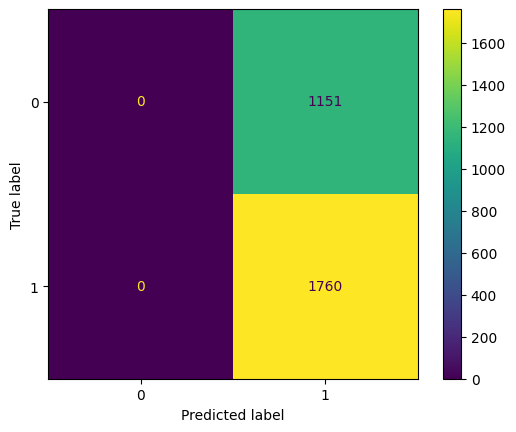

In [19]:
#get baseline value from dummy classifier
dummypipeline=Pipeline([('tr', transformer), ('dummy', DummyClassifier(strategy="most_frequent"))], verbose = True)
TrainML(dummypipeline,X, y )

Training Folds: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

Mean Train AUC --> 0.8836
Mean Validation AUC ---> 0.7818
Mean Train Accuracy --> 0.8900
Mean Validation Accuracy ---> 0.7940


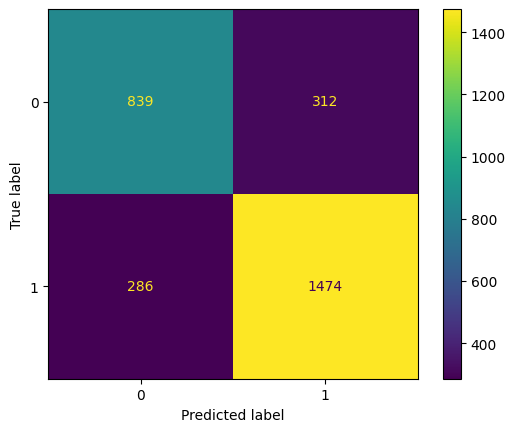

In [20]:
#lgbm classifier
pipeline=Pipeline([('tr', transformer), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
TrainML(pipeline,X, y )

Training Folds: 100%|██████████| 5/5 [00:40<00:00,  8.10s/it]

Mean Train AUC --> 0.8924
Mean Validation AUC ---> 0.7823
Mean Train Accuracy --> 0.8998
Mean Validation Accuracy ---> 0.7949


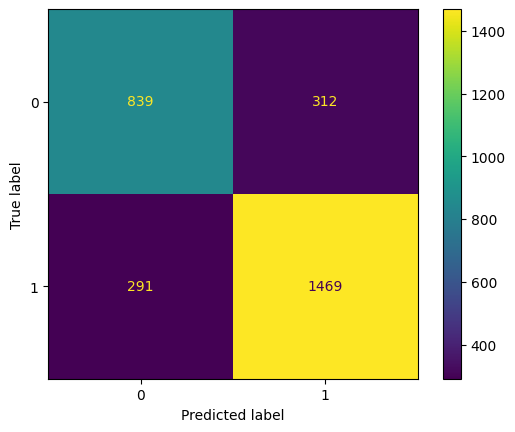

In [21]:
#catboost classifier
pipeline=Pipeline([('tr', transformer), ('cat', CatBoostClassifier(  verbose=False))], verbose = True)
TrainML(pipeline,X, y )

In [22]:
final_features.remove('pass')

In [23]:
[x for x in numeric_columns if 'FB' in x]

['s|max|FB_1']

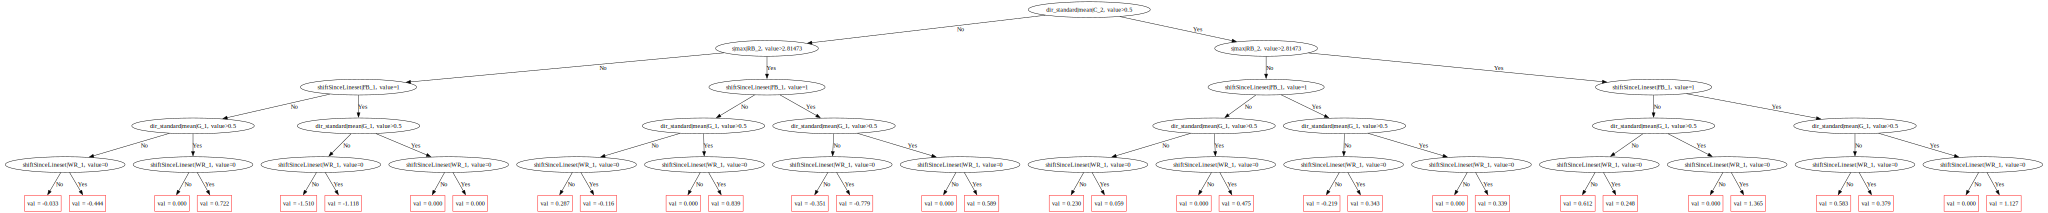

In [24]:
from catboost import  Pool, MetricVisualizer
import ipywidgets as widgets
%matplotlib inline
#need graphviz for this part and to add to path https://graphviz.org/download/

# For explicitly displaying widgets
from IPython.display import display

transformer_impute = ColumnTransformer(
    transformers=[('imputer', imputer, numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

transformer_scale = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

X=train_data[final_features]

y=train_data['pass']
numeric_columns=[]
is_cat = (X.dtypes != float)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna(0, inplace=True)
        X[feature].replace([np.inf, -np.inf], 0, inplace=True)
    else:
        numeric_columns.append(feature)

X_transform=transformer_impute.fit_transform(X)

X_transform = pd.DataFrame(X_transform, columns=final_features)

X_transform=transformer_scale.fit_transform(X_transform)

X_transform = pd.DataFrame(X_transform, columns=final_features)

for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X_transform[feature].fillna(0, inplace=True)
        X_transform[feature].replace([np.inf, -np.inf], 0, inplace=True)
        X_transform[feature]=X_transform[feature].astype(int)

cat_features_index = np.where(is_cat)[0]
pool = Pool(X_transform, y, cat_features=cat_features_index, feature_names=list(X_transform.columns))




model = CatBoostClassifier( max_depth=5,
    verbose=False,  iterations=2).fit(pool)



model.plot_tree(
    tree_idx=1,
    pool=pool
)

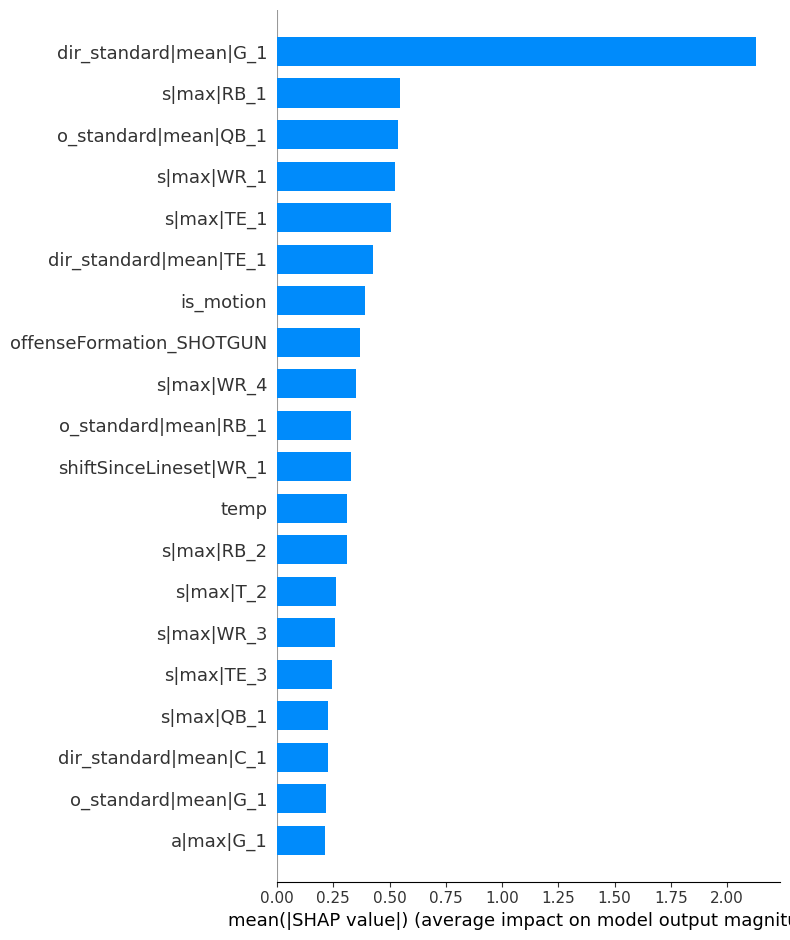

In [25]:
import shap
model = CatBoostClassifier( 
    verbose=False).fit(pool)
shap_values = model.get_feature_importance(Pool(X, label=y, cat_features=cat_features_index),type="ShapValues")
shap_values = shap_values[:, :-1]
shap.summary_plot(shap_values, X, plot_type="bar")

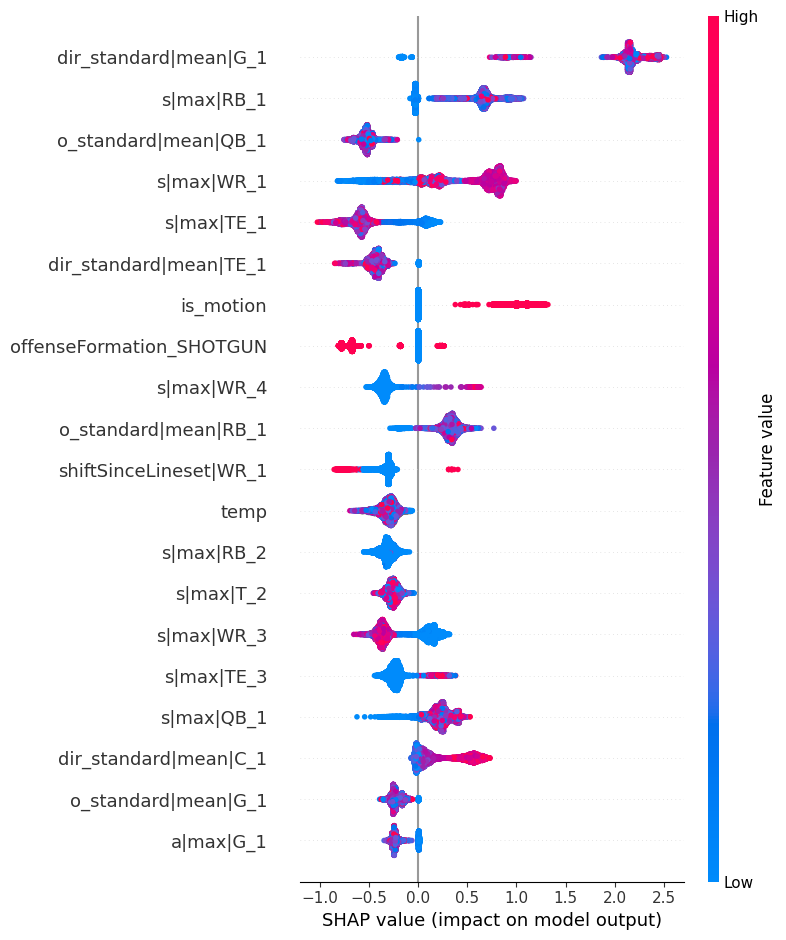

In [26]:
shap.summary_plot(shap_values, X)

In [27]:
importances =model.get_feature_importance(type='PredictionValuesChange')
feature_importances=pd.Series(importances, index=X.columns).sort_values()
feature_importance_df=pd.DataFrame(feature_importances, columns=[ 'importance']).sort_values('importance', ascending=False)
selected_features=list(feature_importance_df.head(len(final_features)).T.columns)
top_30_features=list(feature_importance_df.head(30).T.columns)
top_30_features


['dir_standard|mean|G_1',
 'shiftSinceLineset|WR_1',
 's|max|WR_1',
 'temp',
 'dir_standard|mean|T_2',
 'dir_standard|mean|T_1',
 's|max|T_2',
 'pass_rate_off',
 's|max|QB_1',
 's|max|WR_4',
 's|max|WR_3',
 's|max|RB_2',
 'o_standard|mean|RB_1',
 'dir_standard|mean|C_2',
 'def_xpass',
 's|max|TE_1',
 'motionSinceLineset|TE_2',
 's|max|TE_2',
 's|max|TE_3',
 's|max|FB_1',
 's|max|QB_2',
 'o_standard|mean|WR_2',
 'dir_standard|mean|RB_1',
 'shiftSinceLineset|WR_3',
 'down',
 'shiftSinceLineset|FB_1',
 'shiftSinceLineset|TE_1',
 'dir_standard|mean|QB_1',
 'shiftSinceLineset|T_1',
 's|max|RB_1']

In [28]:
final_cat_columns=[]
for c in cat_columns:
    if c in final_features:
        final_cat_columns.append(c)

In [29]:
final_numeric_columns=[]
for i in final_features:
       if train_data[i].dtype!='O' and i!='pass' and 'shiftSinceLineset' not in i and 'motionSinceLineset' not in i and  'offenseFormation' not in i and'receiverAlignment'not in i and 'Cover'not in i and 'roof' not in i and 'surface' not in i and 'is_no_huddle' not in i and 'is_no_motion' not in i:
            final_numeric_columns.append(i)

In [30]:
from sklearn.compose import ColumnTransformer
# Create a transformer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, final_numeric_columns),
        ('scaler', MinMaxScaler(), final_numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [31]:
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
X=train_data[final_features]

y=train_data['pass']
# Define the helper function so that it can be reused
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20, show_progress_bar=True)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}\n")
    print(f"Optimized parameters: {params}\n")
    return params

def objective(trial):
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 5e-2, 1e-1, log=True),
         "depth": trial.suggest_int("depth",5,8),
        "subsample": trial.suggest_float("subsample", 0.2, .95),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2, .95),
        "iterations":trial.suggest_int("iterations",250, 500 )
        
    }
    cat = CatBoostClassifier(**param,  logging_level='Silent')  
    pipeline=Pipeline([('tr', transformer), ('cat',  cat)], verbose = False)
    scores = cross_val_score( pipeline, X, y, cv=SKF, scoring="accuracy")
    return scores.mean()
#cat_params = tune(objective)

In [32]:
cat_params= {'learning_rate': 0.051007364174007155, 'depth': 7, 'subsample': 0.9376066132270129, 'colsample_bylevel': 0.9446372395814122, 'iterations': 497}

Training Folds: 100%|██████████| 5/5 [00:41<00:00,  8.25s/it]

Mean Train AUC --> 0.9175
Mean Validation AUC ---> 0.7847
Mean Train Accuracy --> 0.9238
Mean Validation Accuracy ---> 0.7968


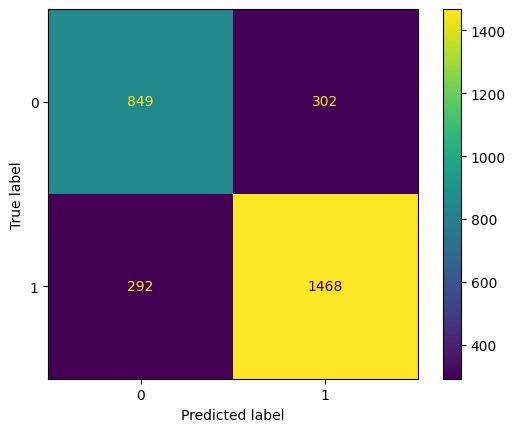

In [33]:
#catboost classifier
pipeline=Pipeline([('tr', transformer), ('cat', CatBoostClassifier(  **cat_params, verbose=False))], verbose = True)
TrainML(pipeline,X, y )

In [34]:
from catboost import CatBoost
transformer_impute = ColumnTransformer(
    transformers=[('imputer', imputer, numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

transformer_scale = ColumnTransformer(
    transformers=[
        ('scaler', MinMaxScaler(), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

X=train_data[final_features]

y=train_data['pass']
numeric_columns=[]
is_cat = (X.dtypes != float)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna(0, inplace=True)
        X[feature].replace([np.inf, -np.inf], 0, inplace=True)
    else:
        numeric_columns.append(feature)

X_transform=transformer_impute.fit_transform(X)

X_transform = pd.DataFrame(X_transform, columns=final_features)

X_transform=transformer_scale.fit_transform(X_transform)

X_transform = pd.DataFrame(X_transform, columns=final_features)

for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X_transform[feature].fillna(0, inplace=True)
        X_transform[feature].replace([np.inf, -np.inf], 0, inplace=True)
        X_transform[feature]=X_transform[feature].astype(int)

cat_features_index = np.where(is_cat)[0]
pool = Pool(X_transform, y, cat_features=cat_features_index, feature_names=list(X_transform.columns))




model = CatBoostClassifier( **cat_params, verbose=False).fit(pool)



In [35]:
from catboost import Pool, cv
cv_dataset = Pool(data=X_transform,
                  label=y,
                  cat_features=cat_features_index)


params = {"iterations": 497,
          "depth": 7,
          "learning_rate":     0.051007364174007155,
          "subsample": 0.9376066132270129,
            "colsample_bylevel":0.9446372395814122,
          "loss_function": "Logloss",
          "eval_metric":'Accuracy',
          "verbose": False}

scores = cv(cv_dataset,
            params,
            fold_count=5,
            
            plot="True")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.7819368132
bestIteration = 483

Training on fold [1/5]

bestTest = 0.7877018207
bestIteration = 397

Training on fold [2/5]

bestTest = 0.7828924768
bestIteration = 493

Training on fold [3/5]

bestTest = 0.7935417382
bestIteration = 475

Training on fold [4/5]

bestTest = 0.8114050155
bestIteration = 420



0.7901902503199308


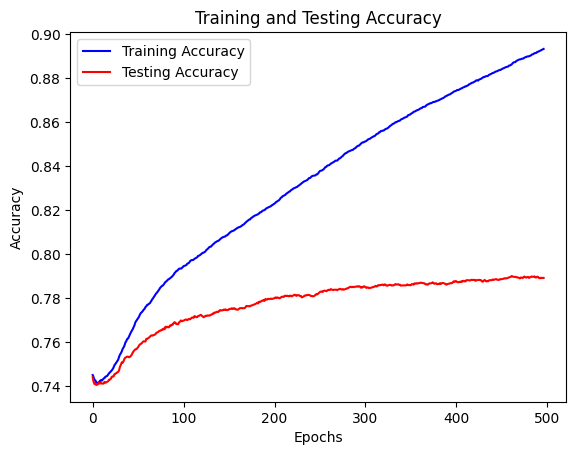

In [36]:
scores
# Plot the accuracy curves
plt.plot(scores['iterations'], scores['train-Accuracy-mean'], 'b', label='Training Accuracy')
plt.plot(scores['iterations'], scores['test-Accuracy-mean'], 'r', label='Testing Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

# Display the pl
print(scores['test-Accuracy-mean'].max())

AUC --> 0.7967476072314782
Accuracy --> 0.8111111111111111


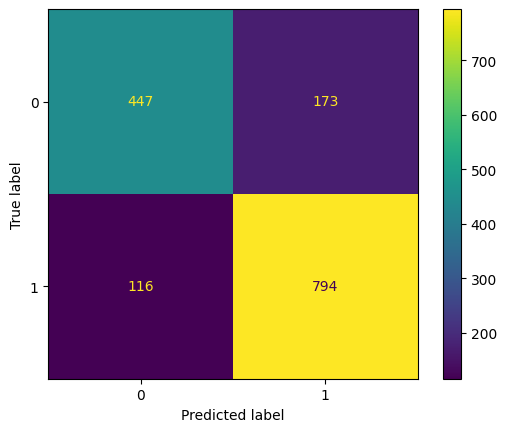

In [37]:
def test_ML(test_data, moddel):
    X=test_data[final_features]
    y_test=test_data['pass']
        
    X_transform=transformer_impute.transform(X)

    X_transform = pd.DataFrame(X_transform, columns=final_features)

    X_transform=transformer_scale.transform(X_transform)

    X_transform = pd.DataFrame(X_transform, columns=final_features)
    for feature, feat_is_cat in is_cat.to_dict().items():
        if feat_is_cat:
            X_transform[feature].fillna(0, inplace=True)
            X_transform[feature].replace([np.inf, -np.inf], 0, inplace=True)
            X_transform[feature]=X_transform[feature].astype(int)

    y_pred=model.predict(X_transform)
    print(f"AUC --> {roc_auc_score(y_test, y_pred)}")
    print(f"Accuracy --> {accuracy_score(y_test, y_pred)}")
    
    
    cm = confusion_matrix(y_test, y_pred)

    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])

    cm_display.plot()
    plt.show()
test_ML(test_data, model)





In [38]:
len(final_features)

61